# CustomCNN Model Evaluation Notebook

In [31]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
from dataset import Paint2CodeDataset
from utils import collate_fn, ids_to_tokens, generate_visualization_object, img_transformation
from modelArchitecture.modelCustomCNN import Encoder, Decoder
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
import pickle
from GUIconverter.GUIconverter import GUIconverter
from IPython.display import display, HTML, Image

## Set parameters

In [32]:
model_file_path = "./modelsCustomCNN/models/ED--epoch-85--loss-0.01651.pth"  #85 9851
data_path = Path("data", "all_data")
use_cuda = True
img_size = 224
split = "validation"
batch_size = 4
seed = 42

In [33]:
# Set random seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print(f"Using device: {device}")

# Ensure the model file exists
assert Path(model_file_path).exists(), "Model file path does not exist"

Using device: cuda


## Load the saved model

In [34]:
loaded_model = torch.load(model_file_path, map_location=device)
vocab = loaded_model["vocab"]

assert vocab is not None, "Vocabulary must be loaded."
len(vocab)

17

## Initialize the models

In [35]:
embed_size = 64
hidden_size = 256
num_layers = 2

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Load model weights
encoder.load_state_dict(loaded_model["encoder_model_state_dict"])
decoder.load_state_dict(loaded_model["decoder_model_state_dict"])

encoder.eval()
decoder.eval()
print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


## Prepare validation data

In [36]:
# Image transformations
transform_imgs = img_transformation(img_size)

# Data loader
data_loader = DataLoader(
    Paint2CodeDataset(data_path, split, vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=False)

## Evaluate model 

In [37]:
predictions = []
targets = []

for i, (image, caption) in enumerate(tqdm(data_loader.dataset)):
    image = image.to(device)
    caption = caption.to(device)
    features = encoder(image.unsqueeze(0))
    sample_ids = decoder.sample(features).cpu().data.numpy()
    
    predictions.append(ids_to_tokens(vocab, sample_ids))
    targets.append(ids_to_tokens(vocab, caption.cpu().numpy()))

bleu_score = corpus_bleu([[target] for target in targets], predictions, smoothing_function=SmoothingFunction().method4)
print(f"BLEU score: {bleu_score:.4f}")

100%|██████████| 169/169 [00:15<00:00, 10.83it/s]

BLEU score: 0.9851


In [38]:
exact_matches = sum([1 for pred, targ in zip(predictions, targets) if pred == targ])
exact_match_ratio = exact_matches / len(predictions)
print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

Exact Match Ratio: 0.7692


In [39]:
total_correct_tokens = 0
total_tokens = 0

for pred, targ in zip(predictions, targets):
    # Предполагаем, что pred и targ уже являются списками токенов
    matched_tokens = sum(1 for p, t in zip(pred, targ) if p == t)
    total_correct_tokens += matched_tokens
    total_tokens += len(targ)

token_accuracy = total_correct_tokens / total_tokens if total_tokens > 0 else 0
print(f"Token Accuracy: {token_accuracy:.4f}")

Token Accuracy: 0.8696


## Visualize predictions

In [40]:
model_name = "CustomCNN"

generate_visualization_object(data_loader.dataset, predictions, targets, model_name)
print("Visualization objects generated.")

PATH_VIS_OBJ = Path("tmpCustomCNN.pkl")

with open(PATH_VIS_OBJ, 'rb') as handle:
    viz_obj = pickle.load(handle)
    
predictions = viz_obj["predictions"]
targets = viz_obj["targets"]
targets_filepaths = viz_obj["targets_filepaths"]

assert predictions and targets and targets_filepaths

Visualization objects generated.


In [41]:
def display_html_string(html_string):
    page = HTML(html_string)
    display(page)

def compare_results(predicted_labels, actual_labels, actual_img_path):
    transpiler = GUIconverter(style='style3')

    #print(f'Predicted HTML. #tokens: {len(predicted_labels)}')
    predicted_html_string = transpiler.transpile(predicted_labels, insert_random_text=True)
    #print(predicted_html_string)
    display_html_string(predicted_html_string)
    
    print(f'Actual image')
    display(Image(str(actual_img_path))) 

Actual image


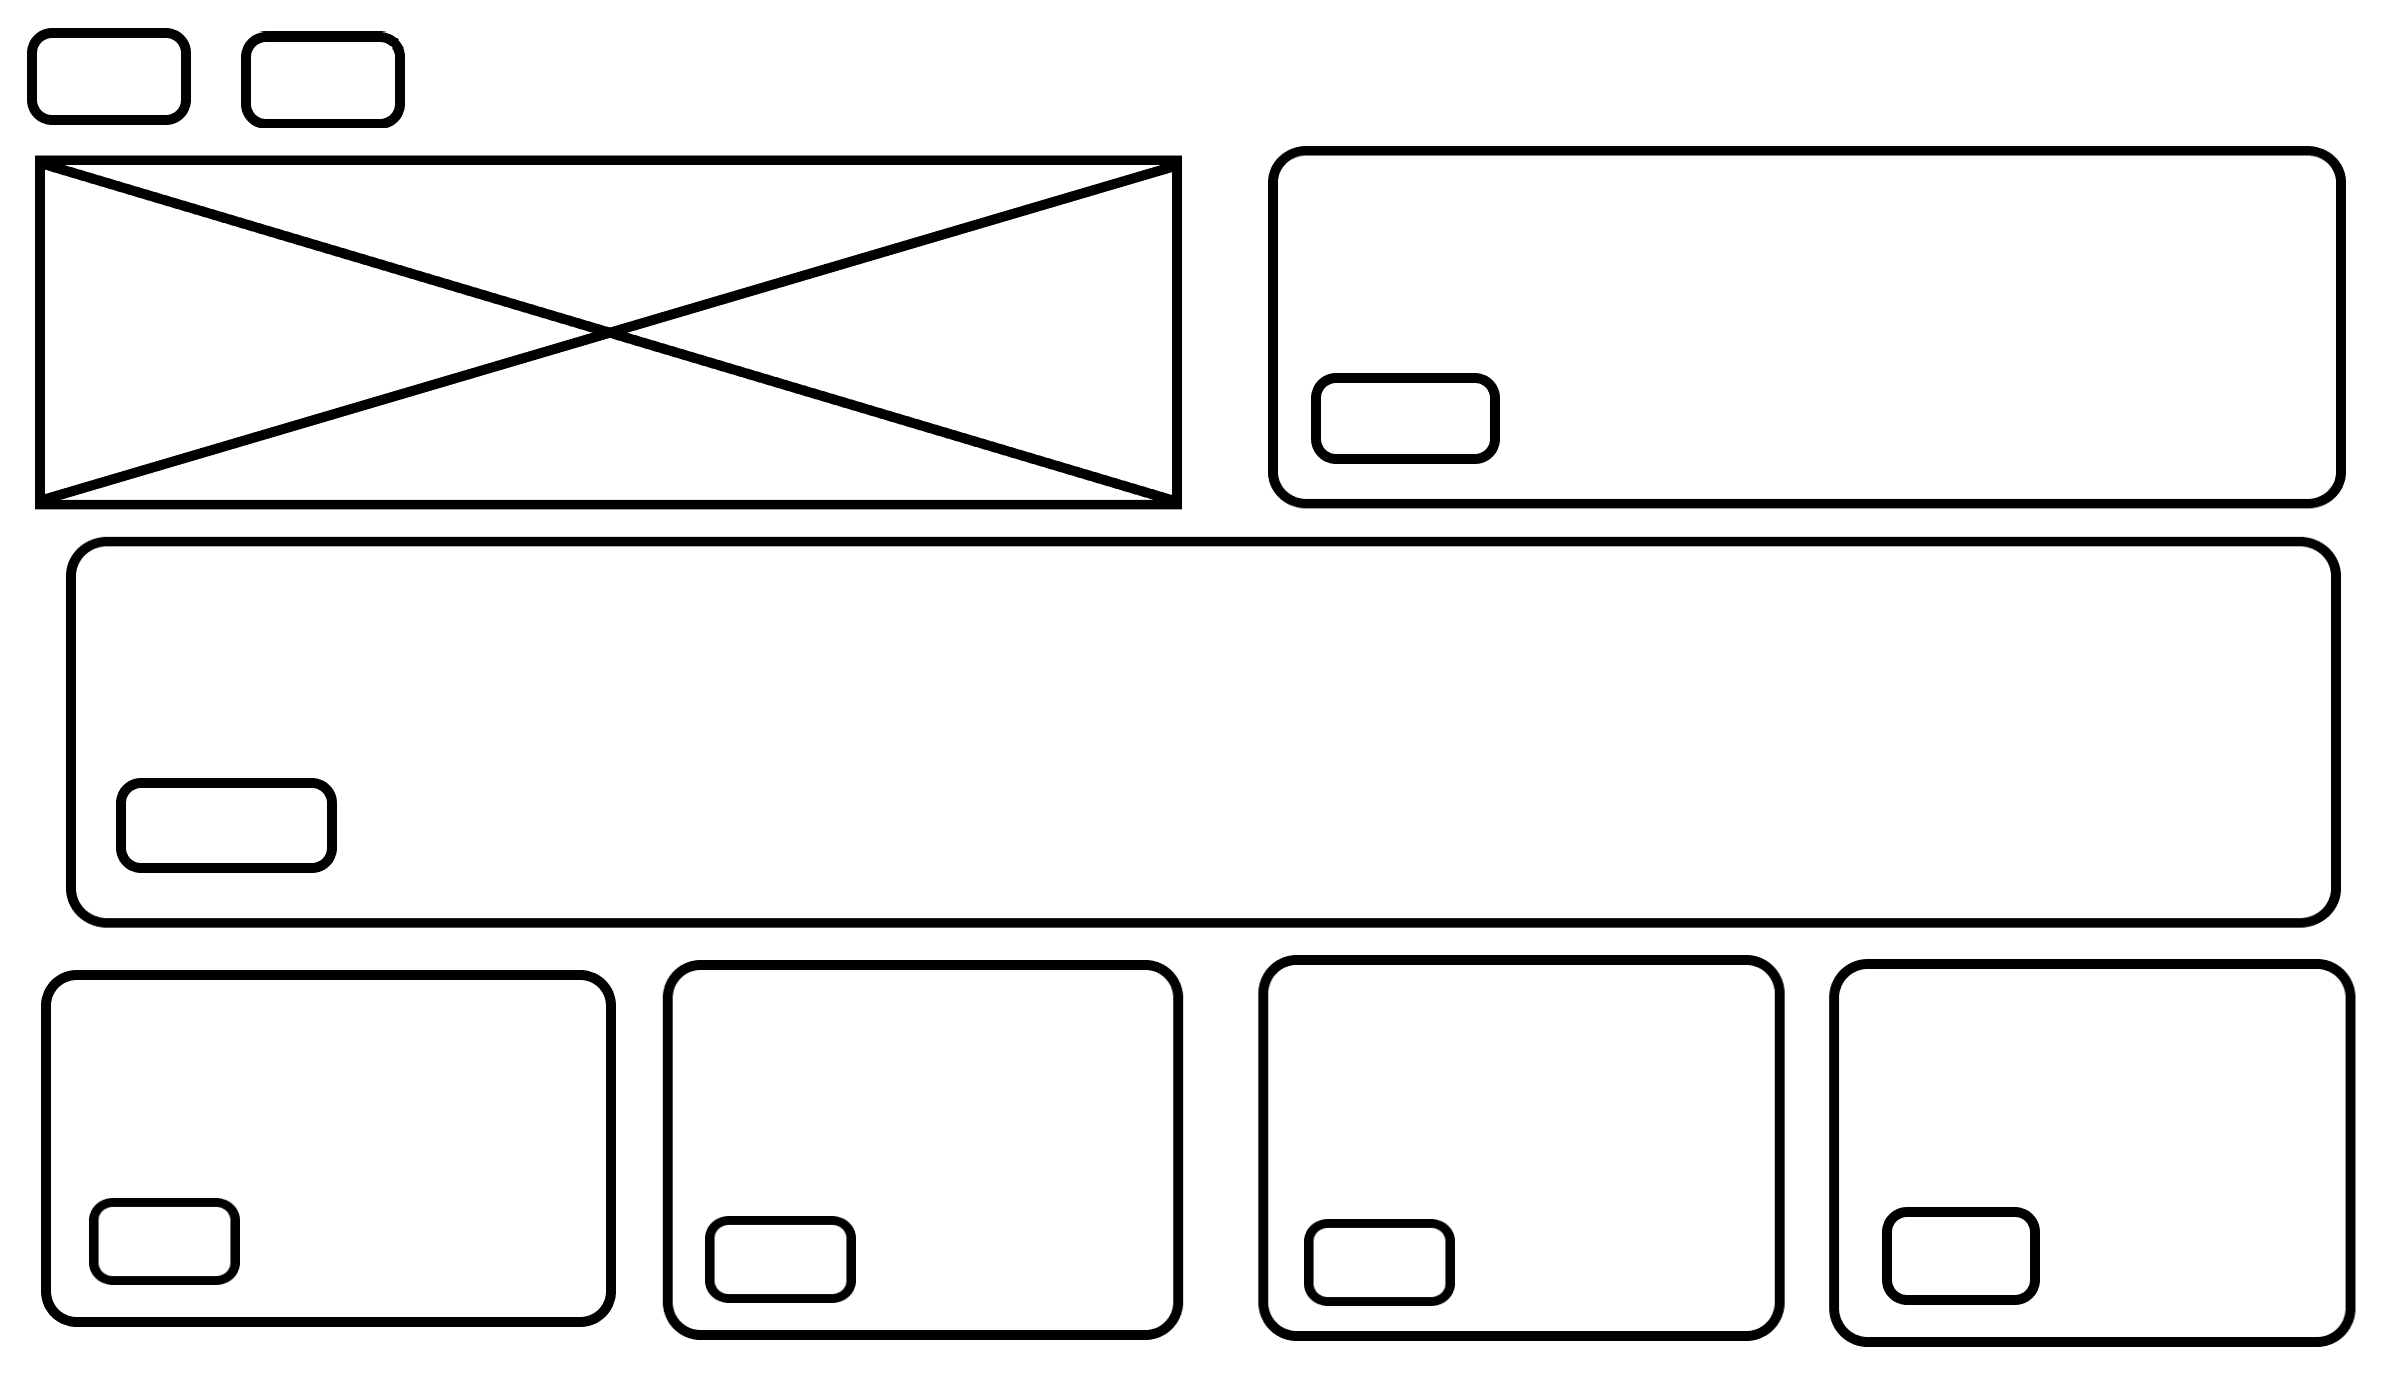

In [42]:
# Change the following variable to test out different results
example_idx = 44 #94 117 23
compare_results(predictions[example_idx], targets[example_idx], targets_filepaths[example_idx])